In [19]:
import pandas as pd
import numpy as np
import pickle
import tokenizer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
# download the pretrained Sentencepiece model from https://github.com/yoheikikuta/bert-japanese
!curl -L -o models/wiki-ja.model "https://drive.google.com/uc?export=download&id=1jjZmgSo8C9xMIos8cUMhqJfNbyyqR0MY"
!curl -L -o models/wiki-ja.vocab "https://drive.google.com/uc?export=download&id=1uzPpW38LcS4YS431GgdG0Hsj4gNgE5X1"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    372      0 --:--:--  0:00:01 --:--:--   372
100  786k  100  786k    0     0   386k      0  0:00:02  0:00:02 --:--:-- 3006k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    491      0 --:--:-- --:--:-- --:--:--   491
100  581k  100  581k    0     0   372k      0  0:00:01  0:00:01 --:--:-- 2317k


In [39]:
# set random state
random_state = 44
np.random.seed(random_state)

## Prepare the dataset

In [40]:
pd.set_option('display.max_columns', None)

local_data_path = './data/tweets_dataset.csv'
df = pd.read_csv(local_data_path, converters={'id':str,'genre':str,'tweet_id':str,'text':str}, encoding='utf-8')
df

,id,genre,tweet_id,text,mixed,positive,negative,neutral,irrelevant
0,10025,10000,522407718091366400,エクスペリアのGPS南北が逆になるのはデフォだったのか。,0,0,1,1,0
1,10026,10000,522407768003592192,xperiaでスクフェス糞\n反応遅いんだよ糞が,0,0,1,0,0
2,10027,10000,522408018642628609,夏春都が持ってたエクスペリアも今使うには辛い,0,0,1,1,0
3,10032,10000,522409063154339840,少し時間空いちゃいましたが、Xperia Z3のカメラ機能について、ちょっとだけですけどまと...,0,0,0,1,0
4,10033,10000,522409073057091584,日向「研磨おたおめー。これプレゼント!!」\n孤爪「こ、これは」\n日向「ビビった?」\n孤...,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
308546,2723564,10021,702906549962805248,KORG Gadget 、iPhone 6s Plusでじゅうぶん動く。KORG Gadge...,0,0,0,1,0
308547,2723932,10021,703558619824926720,あ～ケータイが飛んでる～ あれ？ラッキーの顔がiPhone6だ～まあ私のケータイAndroi...,0,0,0,1,0
308548,2723937,10021,703557929929015297,お風呂上がってぼーっと冷蔵庫の前で\n刑事ドラマの過激なシーンに見とれて\nカバーの付いてな...,0,0,0,1,1
308549,2723939,10021,703557811662262272,iPhone6sローズゴールドにしたゼーイわーい(*^^*),0,0,0,1,0


In [41]:
# show distribution
label_cols = ['mixed', 'positive', 'negative', 'neutral', 'irrelevant']
df[df[label_cols] == 1].describe()

,mixed,positive,negative,neutral,irrelevant
count,1364.0,12295.0,19414.0,135411.0,155507.0
mean,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0


In [42]:
# drop "mixed" and "irrelevant" data
df.drop(index=df[df.mixed == 1].index, inplace=True, axis=0)
df.drop(index=df[df.irrelevant == 1].index, inplace=True, axis=0)

df[df[label_cols] == 1].describe()

,mixed,positive,negative,neutral,irrelevant
count,0.0,11350.0,17856.0,128086.0,0.0
mean,NaN,1.0,1.0,1.0,NaN
std,NaN,0.0,0.0,0.0,NaN
min,NaN,1.0,1.0,1.0,NaN
25%,NaN,1.0,1.0,1.0,NaN
50%,NaN,1.0,1.0,1.0,NaN
75%,NaN,1.0,1.0,1.0,NaN
max,NaN,1.0,1.0,1.0,NaN


In [43]:
# undersample "neutral" data

low_freq_sample = df[df['neutral'] == 0]

neutral_idx = df[(df['neutral'] == 1) & (df['positive'] == 0) & (df['negative'] == 0)].index
random_idx = np.random.choice(neutral_idx, 15000, replace=False)
high_freq_sample = df.loc[random_idx]

undersampled = pd.concat([high_freq_sample, low_freq_sample], ignore_index=True)

df = undersampled
df[df[label_cols] == 1].describe()


,mixed,positive,negative,neutral,irrelevant
count,0.0,9293.0,14446.0,15000.0,0.0
mean,NaN,1.0,1.0,1.0,NaN
std,NaN,0.0,0.0,0.0,NaN
min,NaN,1.0,1.0,1.0,NaN
25%,NaN,1.0,1.0,1.0,NaN
50%,NaN,1.0,1.0,1.0,NaN
75%,NaN,1.0,1.0,1.0,NaN
max,NaN,1.0,1.0,1.0,NaN


In [44]:
X = df['text'].to_numpy()
X[:5]

array(['PCコンパニオン入れてXperiaのバックアップしようとしたけど、なんかバックアップのタブの中身が空白で押すボタンないんだけど。なんだこりゃ。連絡先や予定表も押すボタンがない。グローバルモデルだとあかんのか？',
       '機種変受付中。AQUOS Xxにしちゃいましたお(´・ω・`)',
       'ルンバ氏、ハードだけ買ってソフトはOSS alternativeで代替、とかできないのかな',
       '複合機でスキャンできない薄さだったのでコンビニまで行って濃度あげてコピーし、家でスキャン。冷静に考えれば家でコピーすればよかっただけ。',
       'シャープはおわりやー'], dtype=object)

In [45]:
def determine_label(tweet):
    if tweet['positive']:
        return 0
    elif tweet['negative']:
        return 1
    else:
        return 2

y = [determine_label(tweet) for index, tweet in df.iterrows()]
y[:5]

[2, 2, 2, 2, 2]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

print(len(X_train), len(X_test))

30952 7739


## Setup Vectorizer

In [47]:
tokenizer.tokenize("これは猫です")

['▁これは', '猫', 'です']

In [48]:
vocab = tokenizer.get_vocab()
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize,
                             vocabulary=vocab)
vectorizer.fit(X_train)

CountVectorizer(tokenizer=<function tokenize at 0x7f94e3edf550>,
                vocabulary=['<unk>', '<s>', '</s>', '[PAD]', '[CLS]', '[SEP]',
                            '[MASK]', '、', '。', '▁', 'の', 'は', 'が', '・', ')',
                            '(', '年', 'に', 'を', 'で', 'と', '」', '月', '「', '1',
                            '2', 'や', 'である', 'から', 'した', ...])

In [49]:
X_train_vec = vectorizer.transform(X_train)
X_train_vec

<30952x32000 sparse matrix of type '<class 'numpy.int64'>'
	with 796660 stored elements in Compressed Sparse Row format>

## Create Naive Bayes Model

In [50]:
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

MultinomialNB()

In [51]:
X_test_vec = vectorizer.transform(X_test)
X_test_vec

<7739x32000 sparse matrix of type '<class 'numpy.int64'>'
	with 196960 stored elements in Compressed Sparse Row format>

## Evaluate the model

In [52]:
clf.score(X_test_vec, y_test)

0.7219278976611966

In [56]:
examples = [
    "これはナイーブベイズ分類機を使った最高に素晴らしいAPIです。",
    "これはナイーブベイズ分類機を使っているがそれほど精度は高くないので使い物にならないと思う。",
]

clf.predict_proba(vectorizer.transform(examples))

array([[0.99101173, 0.00105572, 0.00793255],
       [0.26302049, 0.73088628, 0.00609323]])

Accuracy: 0.72
Auc: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1859
           1       0.72      0.78      0.75      2880
           2       0.74      0.69      0.72      3000

    accuracy                           0.72      7739
   macro avg       0.72      0.72      0.72      7739
weighted avg       0.72      0.72      0.72      7739



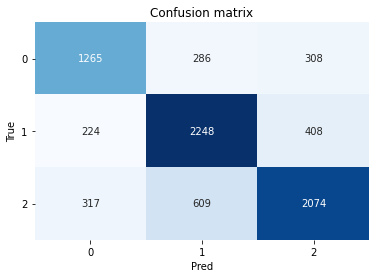

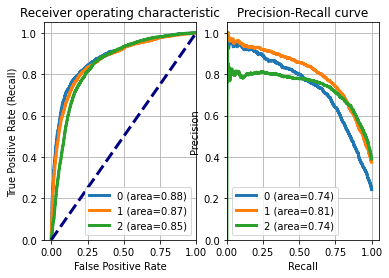

In [54]:
predicted = clf.predict(vectorizer.transform(X_test))
predicted_prob = clf.predict_proba(vectorizer.transform(X_test))

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## Save the models

In [55]:
with open('./models/bayes.pickle', mode='wb') as f:
    pickle.dump(clf, f)

with open('./models/vectorizer.pickle', mode='wb') as f:
    pickle.dump(vectorizer, f)